<a href="https://colab.research.google.com/github/biomechatronics-research-team/ClassificationAlgorithm/blob/master/BioMechatronic_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#libraries for fourier transform
from __future__ import division # use so 1/2 = 0.5, etc.
%pylab inline
!pip install git+https://github.com/mwickert/scikit-dsp-comm.git
import sk_dsp_comm.sigsys as ss  #library containing triangular pulse
import numpy as np
from numpy import fft as fourier
import matplotlib.pyplot as plt

In [0]:
#code to generate the function, this can be changed for real data
t = arange(-5,5,0.05)  #Time axis and steps 
x = ss.tri(2*t,7) * np.exp(-(abs(5*(t/11))))  * np.cos((5*pi *t) + pi/6) #equation x(t)
noise = np.sqrt(np.var(x)/10**(0.1/10.))*np.random.randn(len(x)); #Noise signal
#x += noise
plot(t,x)  
grid()
xlabel(r'Time (s)')
ylabel(r'$\Lambda((2*(t/7)) * e ^{(-|5*t/2|)} *  cos (5 \pi t - \pi /6)$');
tight_layout()

In [0]:
#code for the fourier transform
n = len(x)  # I think this maight be the number of steps for the transform
transform = fourier.fft(x)/n
transform = fourier.fftshift(transform)
transform *= np.conjugate(transform)
plot(t,transform)

# Butterworth filter

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


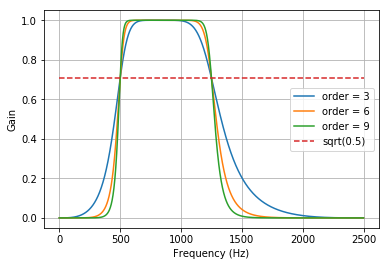

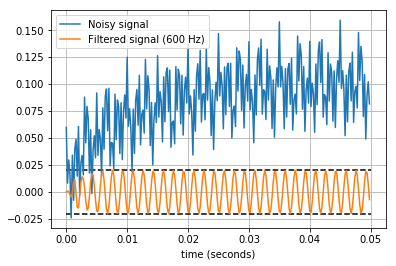

In [0]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def run():
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 5000.0
    lowcut = 500.0
    highcut = 1250.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.

    # Creating synthetic signal
    T = 0.05
    nsamples = T * fs
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.d()
    plt.plot(t, x, label='Noisy signal')

    #applying filter
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()


run()

# Kristalys' code

In [0]:
import numpy as np
from keras import layers
from keras.layers import recurrent
from keras.models import Model
from keras.layers import Input, Activation, Dense, Permute, Dropout

# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
answer = LSTM(32)(answer)  # (samples, 32)

# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=120,
          validation_data=([inputs_test, queries_test], answers_test))